In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib notebook

In [8]:
# read the output of aperture extraction 
sentinel_data = np.genfromtxt('WASP-52_example/reduced/sentinel_03_06_run01.dat')

# 0: nf 
# 1: name
# 2: min
# 3: expt
# 4: x
# 5: y 
# 6: dx
# 7: dy
# 8: xr
# 9: yr
# 10: fw
# 11: peak
# 12: a1
# 13: a2
# 14: r1
# 15: r2
# 16: lc1
# 17: lc2
# 18: sky
# 19: abflux



<IPython.core.display.Javascript object>


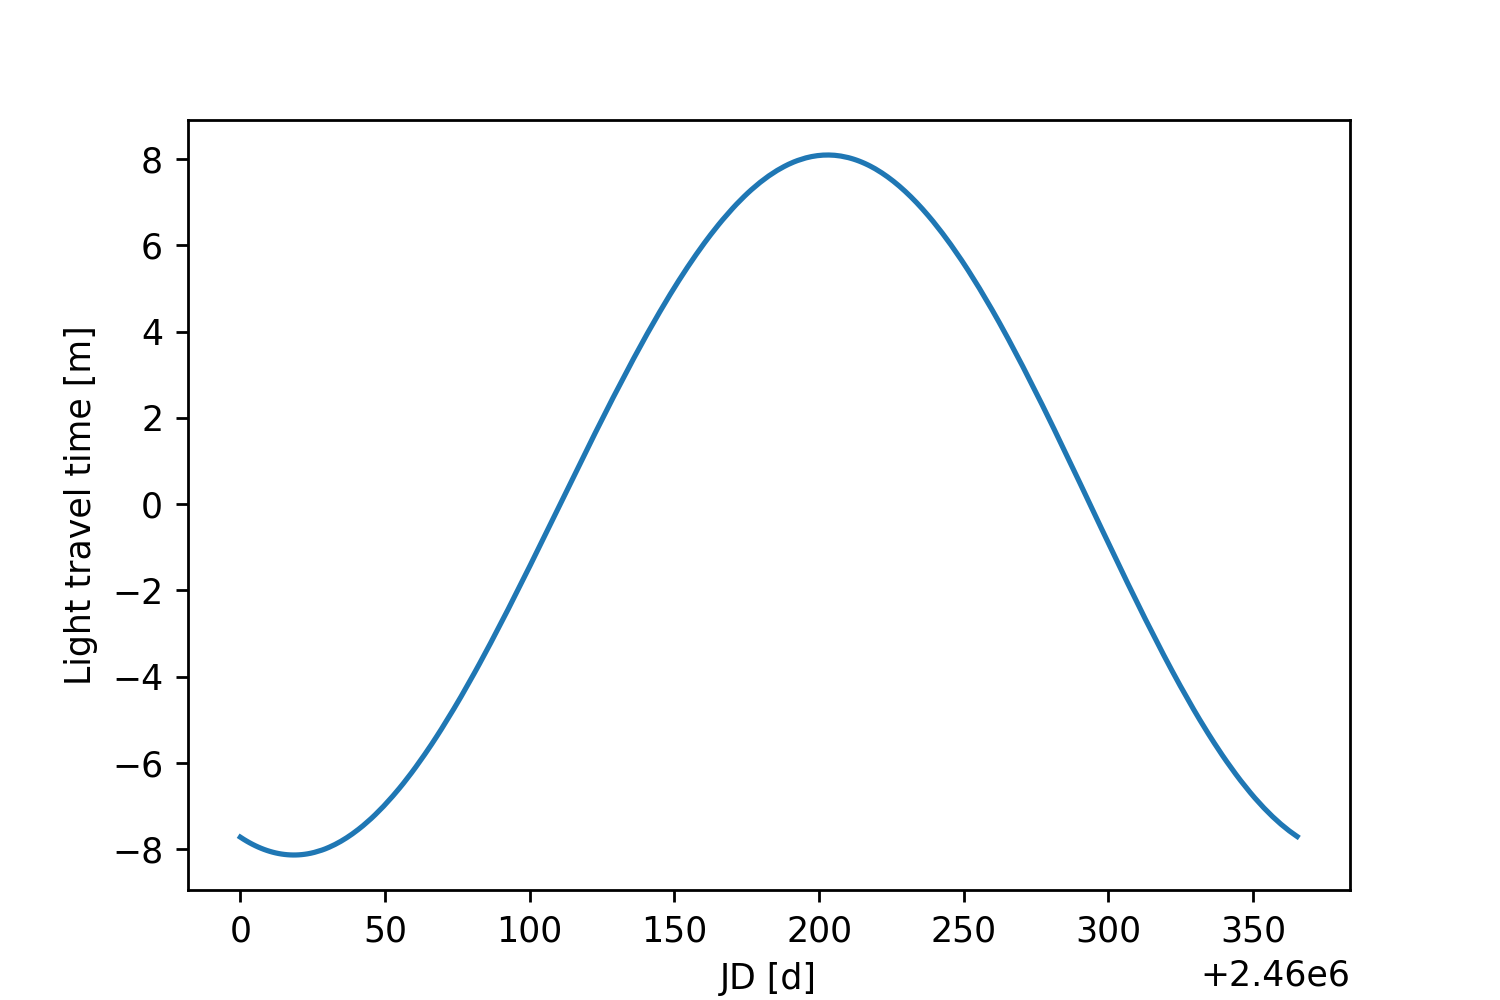

<SkyCoord (BarycentricMeanEcliptic: equinox=J2000.000): (lon, lat) in deg
    (352.92073514, 12.60110778)>

In [9]:
# T0: from the header of the first scientific frame 
# JD = 2457284.410320 / JD at start
jd = (sentinel_data[:,2]/1440.) + 2457284.410320 + sentinel_data[:,3]/86400./2. 

from astropy.time import Time
#https://docs.astropy.org/en/stable/time/
tm = Time(jd, format='jd', scale='utc', location=('45.8472d', '11.569d')) 

# Asiago - Cima Ekar
# 45° 50' 50'' N -> 45.8472
# 11° 34' 08'' E -> 11.569

# Conversion from JD-UTC to TDB
# tm.tdb[:5]
# BUT: the results would be in Earth barycentric system. 
# In order to move from the Earth BC to the Solar System BC 
# we have to correct for the "light travel time", i.e.,
# the time required by the light to travel between Earth 
# and the Solar System barycenter 

from astropy import coordinates as coord, units as u
target = coord.SkyCoord("23:13:58.76", "+08:45:40.57", unit=(u.hourangle, u.deg), frame='icrs')
ltt_bary = tm.light_travel_time(target)  


#print(' Light travel time in minutes:')
#print(ltt_bary.to_value(u.min))


# let's compute the light travel time for one year of observations 
jd_plot = np.arange(2460000, 2460365.25, 0.10)
tm_plot = Time(jd_plot, format='jd', scale='utc', location=('45.8472d', '11.569d')) 
ltt_plot = tm_plot.light_travel_time(target)  

plt.figure(figsize=(6,4))
plt.plot(jd_plot, ltt_plot.to_value(u.min))
plt.xlabel('JD [d]')
plt.ylabel('Light travel time [m]')
plt.show()

target.transform_to(frame='barycentricmeanecliptic')


In [10]:
# BJD_TDB is given by the sum of the time at the Earth barycenter + the ligh travel time
# But note that "tm" and "ltt_bary" are NOT arrays but objects. 
# type(tm) -> astropy.time.core.Time
# type(ltt_bary) -> astropy.time.core.DeltaTime


# They are two different kinds of objects as well! According to the documentation, 
# the first one is converted to an array by using 
# tm.tdb.to_value('jd')
#
# The second one using
# ltt_bary.to_value(u.d)
#
bjd_tdb = tm.tdb.to_value('jd') + ltt_bary.to_value(u.d)



In [11]:
# you can double check here http://astroutils.astronomy.ohio-state.edu/time/
print('Input values for website:')
print(jd[:4])
print('Output value to be compared')
print(bjd_tdb[:4])

print('Compute the difference in seconds')
print((2457284.41680402 - 2457284.416803980)*86400)



Input values for website:
[2457284.41033736 2457284.41041375 2457284.41048319 2457284.41055958]
Output value to be compared
[2457284.41680402 2457284.4168804  2457284.41694985 2457284.41702624]
Compute the difference in seconds
0.0034600496292114258


<IPython.core.display.Javascript object>


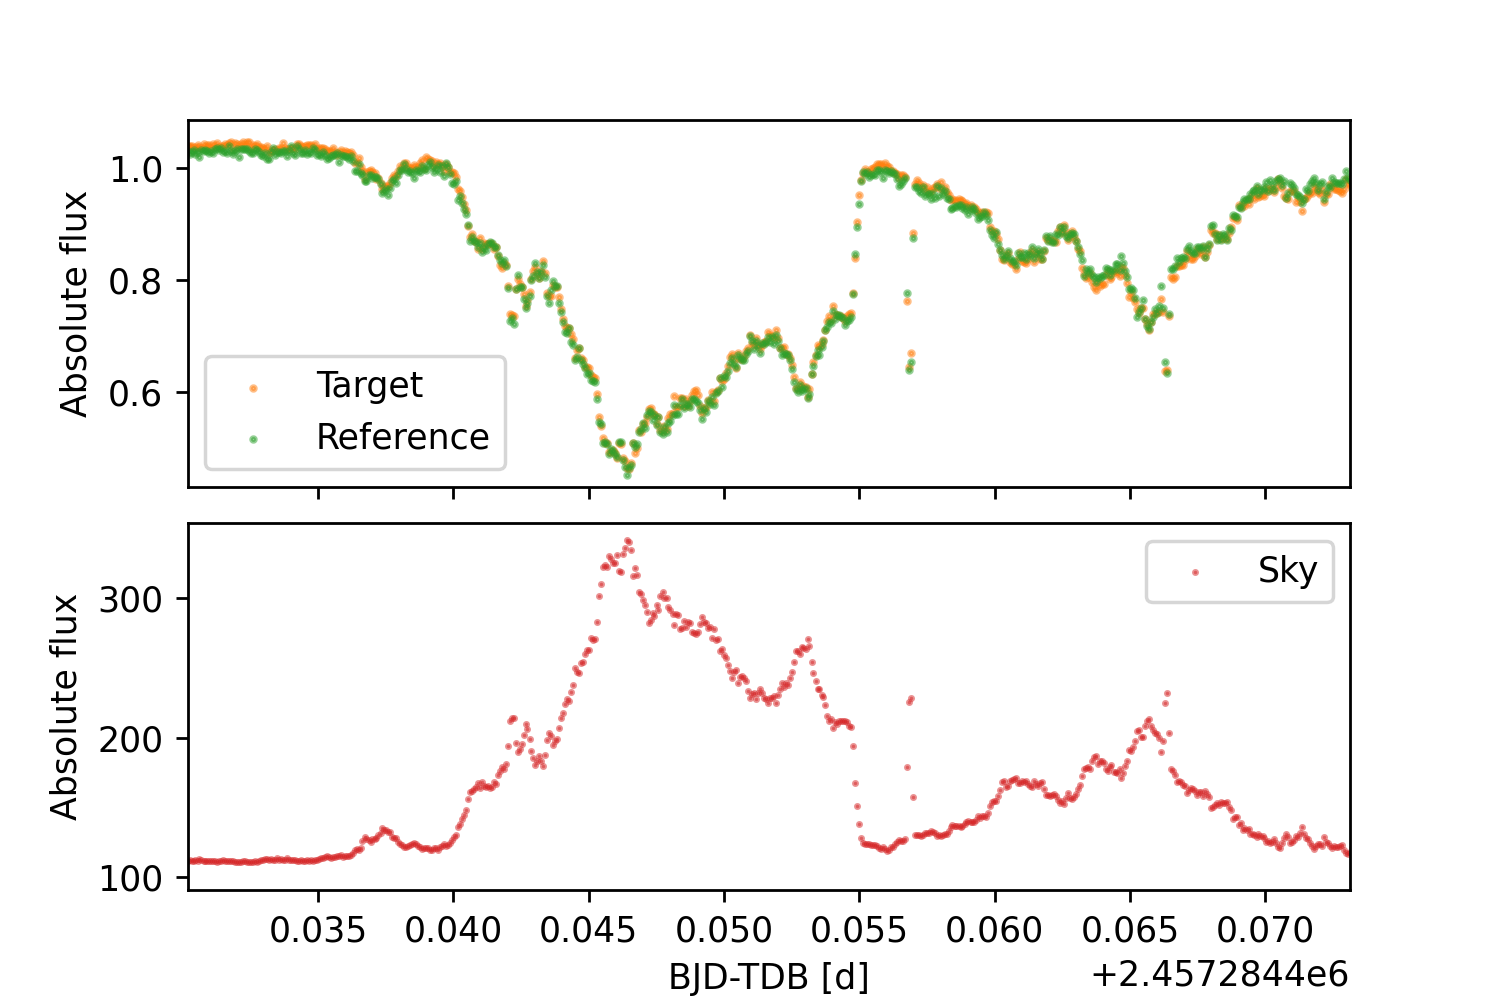

In [14]:
# Plot: "raw" light curve of target and reference

# 13: a2
# 15: r2
# 18: sky

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data[:,13]/np.median(sentinel_data[:,13]), c='C1', s=2, alpha=0.5, label='Target')
ax1.scatter(bjd_tdb, sentinel_data[:,15]/np.median(sentinel_data[:,15]), c='C2', s=2, alpha=0.5, label='Reference')
ax2.scatter(bjd_tdb, sentinel_data[:,18], c='C3', s=1, alpha=0.5, label='Sky')

# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Absolute flux')
ax2.set_ylabel('Absolute flux')

ax1.legend()
ax2.legend()
plt.show()


107.369


<IPython.core.display.Javascript object>


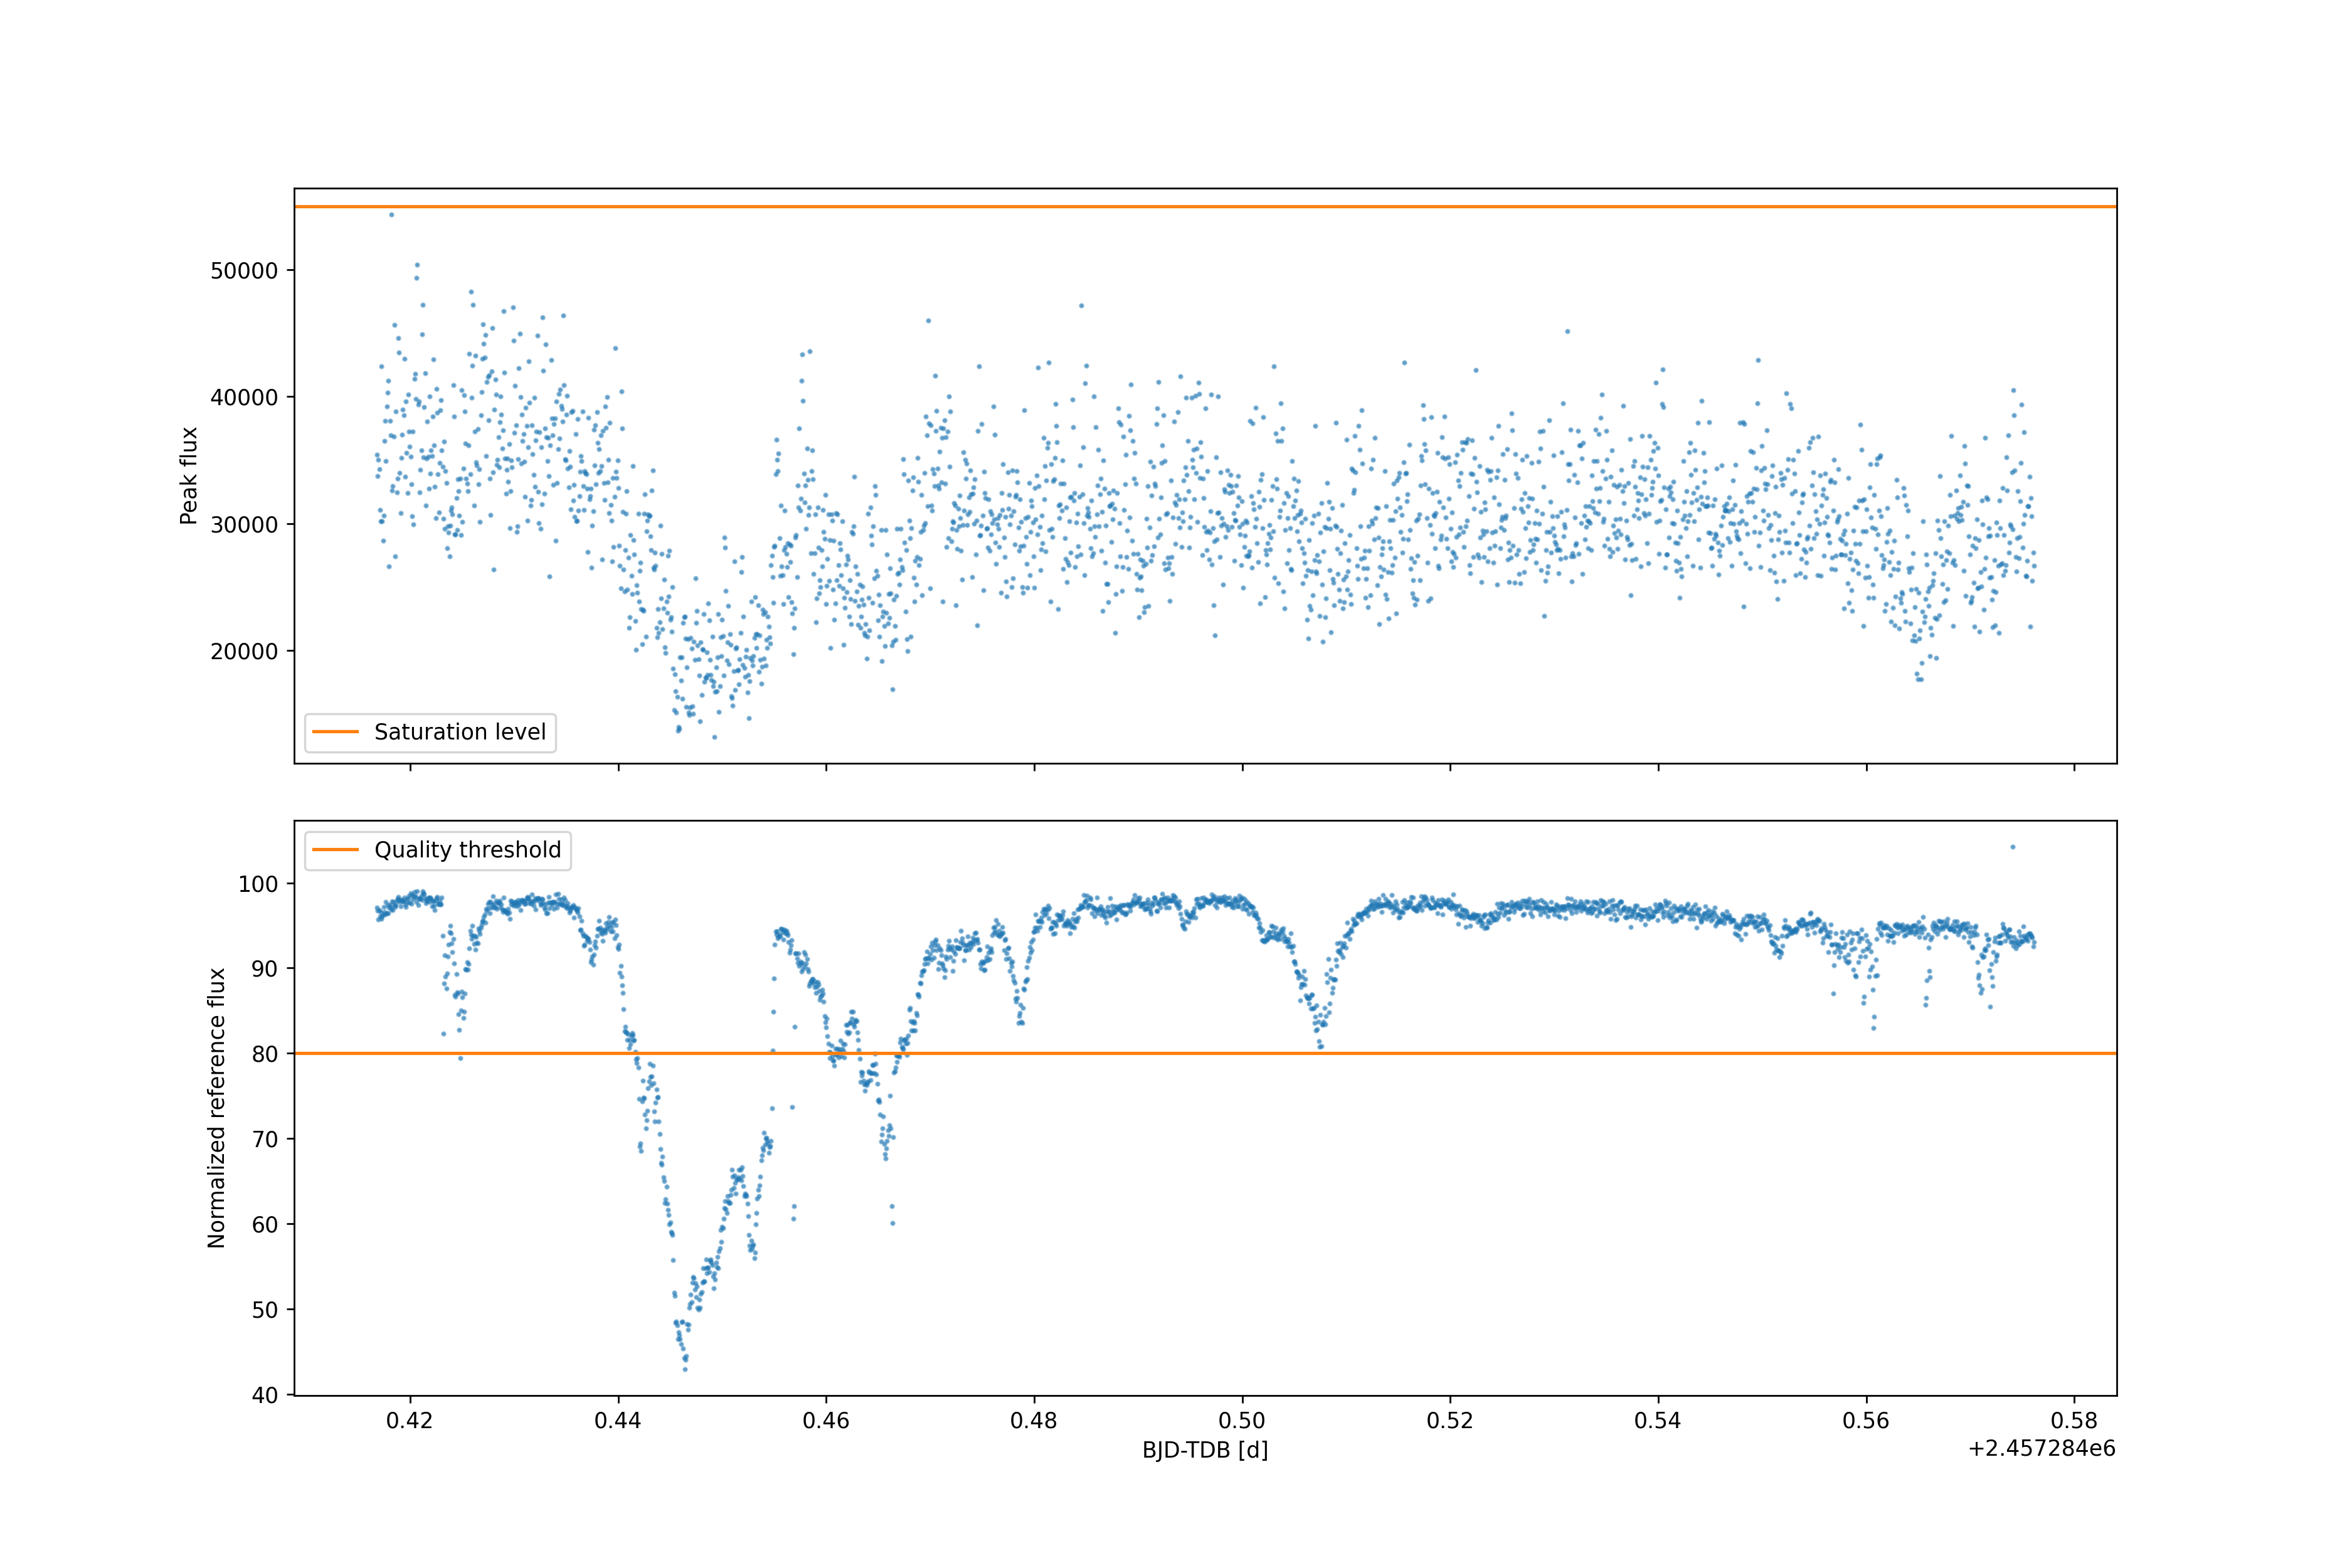

In [18]:
# Plot 1: Check if either the peak value of BOTH aperture is below the saturation level, 
# Plot 1: check if the reference star has a stable flux:

# 11: peak
# 19: abflux

ab_max = np.amax(sentinel_data[:,19])
print(ab_max)
ab_max = 103.
ab_rescaled = sentinel_data[:,19]/ab_max * 100.00 

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

ax1.scatter(bjd_tdb, sentinel_data[:,11], c='C0', s=2, alpha=0.5)
ax1.axhline(55000, c='C1', label='Saturation level')

ax2.scatter(bjd_tdb, ab_rescaled, c='C0', s=2, alpha=0.5)
ax2.axhline(80, c='C1', label='Quality threshold')



# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Peak flux')
ax2.set_ylabel('Normalized reference flux')

ax1.legend()
ax2.legend()
plt.show()

quality_selection = (sentinel_data[:,11] < 55000) & (ab_rescaled > 80)

<IPython.core.display.Javascript object>


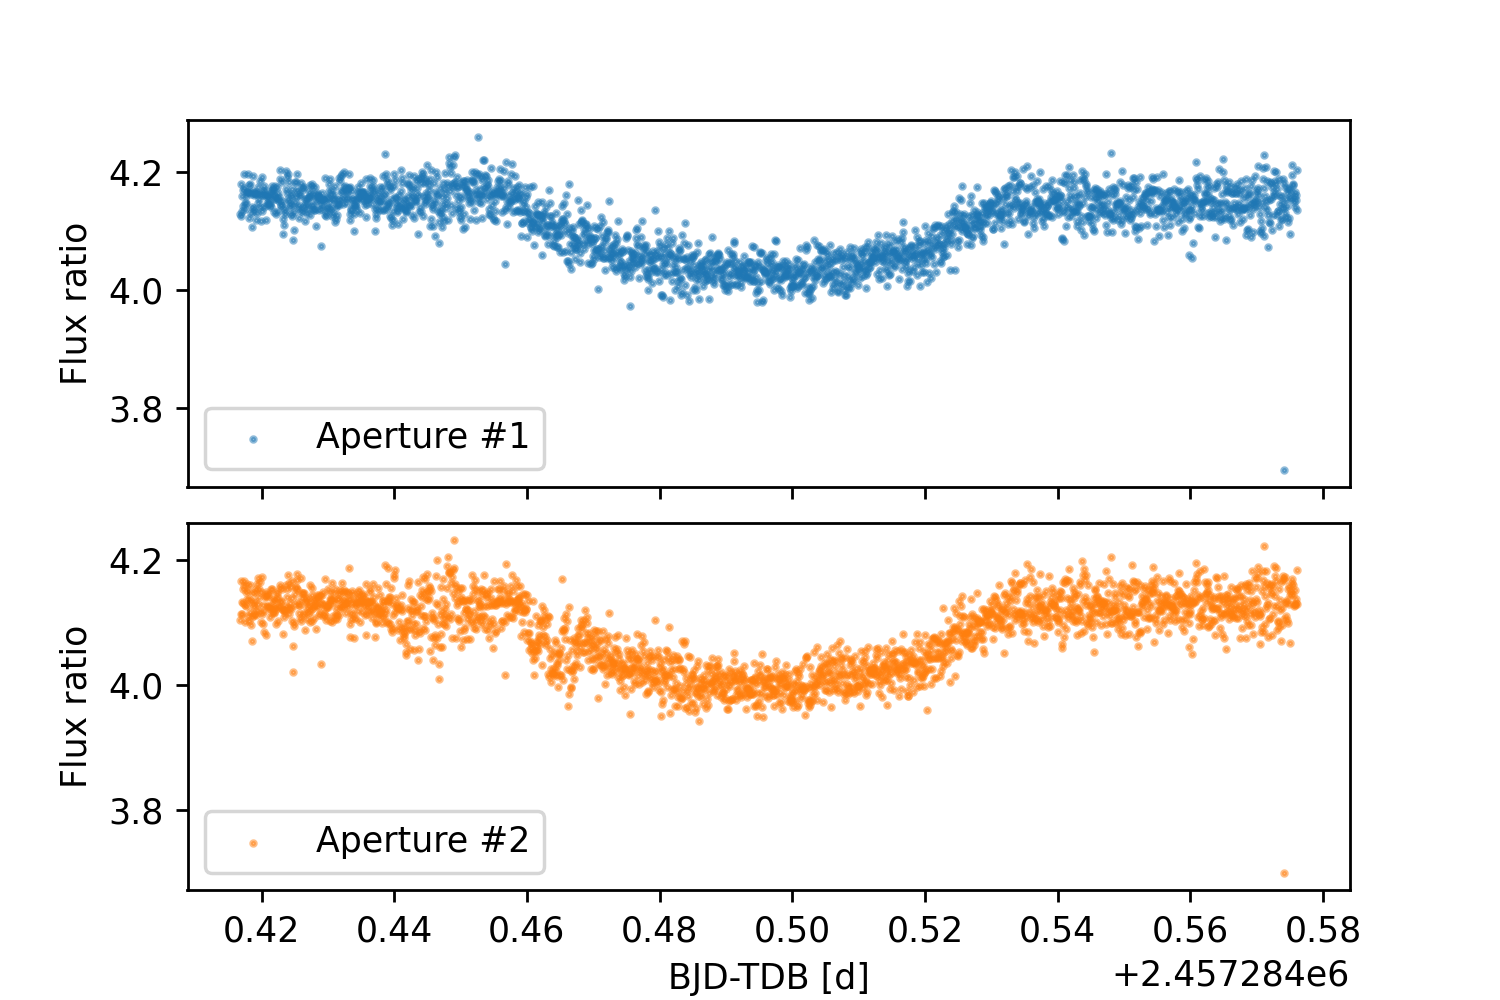

In [20]:
# Plot: ratio of target flux divided by the reference flux 

# Aperture #1
# 12: a1
# 14: r1
# 16: lc1 = a1/r1

# Aperture #2
# 13: a2
# 15: r2
# 17: lc2 = a2/r2

# For a better comparison, we devided by the median 
median_aperture1 = np.median(sentinel_data[:,16])
median_aperture2 = np.median(sentinel_data[:,17])

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
# remove vertical gap between subplots
plt.subplots_adjust(hspace=.1)

#ax1.scatter(bjd_tdb, sentinel_data[:,16] / median_aperture1, c='C0', s=2, alpha=0.5, label='Aperture #1')
#ax2.scatter(bjd_tdb, sentinel_data[:,17] / median_aperture2, c='C1', s=2, alpha=0.5, label='Aperture #2')


ax1.scatter(bjd_tdb, sentinel_data[:,16] , c='C0', s=2, alpha=0.5, label='Aperture #1')
ax2.scatter(bjd_tdb, sentinel_data[:,17] , c='C1', s=2, alpha=0.5, label='Aperture #2')



# mind the difference with plt.xlabel
# use ax1 or ax2 depending on where do you want the labels
ax2.set_xlabel('BJD-TDB [d]')

ax1.set_ylabel('Flux ratio')
ax2.set_ylabel('Flux ratio')

ax1.legend()
ax2.legend()
plt.show()



In [9]:
# Error computation
lc1_err = sentinel_data[:,16] * np.sqrt(  1./ sentinel_data[:,12] +   1./ sentinel_data[:,14]   )
lc2_err = sentinel_data[:,17] * np.sqrt(  1./ sentinel_data[:,13] +   1./ sentinel_data[:,15]   )
# Is it correct? it may be, it may not.... 
# Check the error propagation, assuming the standard error for poisson counting...


In [11]:
# Saving to a file using the PyORBIT standard
# lightcurve normalization will be included in the model
# 

fileout = open('WASP-52_TASTE_aperture1.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection]-2450000.0, sentinel_data[quality_selection,16], lc1_err[quality_selection]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()

fileout = open('WASP-52_TASTE_aperture2.dat', 'w')
for b, f, e in zip(bjd_tdb[quality_selection]-2450000.0, sentinel_data[quality_selection,17], lc2_err[quality_selection]):
    fileout.write('{0:12.9f} {1:12.9f} {2:12.9f} 0 \n'.format(b,f,e))
fileout.close()